In [31]:
# load json file as dictionary
import json
import sys
import pandas as pd
import numpy as np
import re

from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import bertopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
import datamapplot
import nbformat


In [3]:
unseen_data_labelled = pd.read_csv("unseen_data_predictions_20240704-114801.csv")
patents_text = pd.read_csv("patents_text_deduplicated.csv")
training_data = pd.read_csv("training_data_new3.csv")

/var/folders/jy/j77v476x03737ryp7gll_0p00000gn/T/ipykernel_1094/1228290111.py:2: DtypeWarning: Columns (18,20,21,23,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  patents_text = pd.read_csv("patents_text_deduplicated.csv")


In [4]:
len(patents_text)

20445

In [5]:
len(unseen_data_labelled.publication_number_EPO)

19457

In [6]:
# Create dictionaries for quick lookup, handling non-unique indices
unseen_data_dict = unseen_data_labelled.drop_duplicates(subset='publication_number_EPO').set_index('publication_number_EPO')[['predicted_SofAI', 'predicted_AIforS']].to_dict(orient='index')
training_data_dict = training_data.drop_duplicates(subset='publication_number_EPO').set_index('publication_number_EPO')[['SofAI', 'AIforS']].to_dict(orient='index')

# Function to determine SofAI and AIforS values
def get_values(pub_number):
    if pub_number in unseen_data_dict:
        return unseen_data_dict[pub_number]['predicted_SofAI'], unseen_data_dict[pub_number]['predicted_AIforS']
    elif pub_number in training_data_dict:
        return training_data_dict[pub_number]['SofAI'], training_data_dict[pub_number]['AIforS']
    else:
        return None, None

# Apply the function to the patents_text dataframe
patents_text['SofAI'], patents_text['AIforS'] = zip(*patents_text['publication_number_EPO'].apply(get_values))

In [7]:
# Count the occurrences for each category
only_SofAI = ((patents_text['SofAI'] == 1) & (patents_text['AIforS'] == 0)).sum()
only_AIforS = ((patents_text['SofAI'] == 0) & (patents_text['AIforS'] == 1)).sum()
both = ((patents_text['SofAI'] == 1) & (patents_text['AIforS'] == 1)).sum()
none = ((patents_text['SofAI'] == 0) & (patents_text['AIforS'] == 0)).sum()

# Print the counts
print(f"Number of rows with only SofAI set to 1: {only_SofAI}")
print(f"Number of rows with only AIforS set to 1: {only_AIforS}")
print(f"Number of rows with both SofAI and AIforS set to 1: {both}")
print(f"Number of rows with neither SofAI nor AIforS set to 1: {none}")


Number of rows with only SofAI set to 1: 548
Number of rows with only AIforS set to 1: 17302
Number of rows with both SofAI and AIforS set to 1: 2500
Number of rows with neither SofAI nor AIforS set to 1: 95


In [9]:
patents_text.to_csv("patents_text_topic_modelling2.csv", index=False)

In [32]:
patents_text = pd.read_csv("patents_text_topic_modelling2.csv")

/var/folders/jy/j77v476x03737ryp7gll_0p00000gn/T/ipykernel_8626/3127923996.py:1: DtypeWarning: Columns (18,20,21,23,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  patents_text = pd.read_csv("patents_text_topic_modelling2.csv")


# Topic Modelling: Bertopic

In [33]:
patents_text['title'] = patents_text['title'].fillna('')
patents_text['abstract'] = patents_text['abstract'].fillna('')
patents_text['description'] = patents_text['description'].fillna('')
patents_text['claims'] = patents_text['claims'].fillna('')

## Sustainability of AI

In [34]:
sofai = patents_text[(patents_text['SofAI'] == 1) & (patents_text['AIforS'] == 0)]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = sofai['title'] + sofai['abstract'] + sofai["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [35]:
# precalculate embeddings: 
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)
embeddings_specter = embedding_model_specter.encode(abstracts, show_progress_bar=True)        


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [11]:
# precalculate embeddings: 
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", revision=None)
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches: 100%|██████████| 18/18 [00:03<00:00,  4.53it/s]


In [11]:
# prevent stochastic behaviour
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [12]:
# control number of topics
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [13]:
# improve representation by preprocessing topic representations after documents are assigned
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

In [14]:
# use additional representations
# KeyBERT
keybert_model = KeyBERTInspired()

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model
}

In [15]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings)

# Show topics
topic_model.get_topic_info()

2024-07-05 10:02:01,828 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-05 10:02:03,986 - BERTopic - Dimensionality - Completed ✓
2024-07-05 10:02:03,987 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-05 10:02:04,009 - BERTopic - Cluster - Completed ✓
2024-07-05 10:02:04,011 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-05 10:02:05,650 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,510,0_data_power_processing_method,"[data, power, processing, method, network, dev...","[computing, processing, processor, neural netw...","[data, power, processing, method, network, dev...",[method and apparatus for optimizing deep lear...
1,1,38,1_voice_signal_recognition_input,"[voice, signal, recognition, input, device, no...","[voice input, voice recognition, electronic de...","[voice, signal, recognition, input, device, no...",[audio device and computer readable program[pr...


In [21]:
topic_model.get_topic(1, full=True)

{'Main': [('battery', 0.05867696602326208),
  ('cell', 0.02011352866022289),
  ('battery module', 0.017143982363561072),
  ('battery cell', 0.016524461869198),
  ('battery management', 0.01363065910475089),
  ('battery cells', 0.013324590429795766),
  ('cells', 0.013186704237271423),
  ('pack', 0.013092554739447013),
  ('module', 0.012946796873166909),
  ('battery pack', 0.012784410396982094)],
 'KeyBERT': [('battery modules', 0.6078744),
  ('battery module', 0.6067715),
  ('plurality battery', 0.5852642),
  ('battery management', 0.5544896),
  ('connected battery', 0.545168),
  ('battery cells', 0.5448852),
  ('relates battery', 0.54103947),
  ('battery cell', 0.5365859),
  ('battery control', 0.5237458),
  ('battery monitoring', 0.50716454)],
 'MMR': [('battery', 0.05867696602326208),
  ('cell', 0.02011352866022289),
  ('battery module', 0.017143982363561072),
  ('battery cell', 0.016524461869198),
  ('battery management', 0.01363065910475089),
  ('battery cells', 0.01332459042979576

## guided topic modelling

In [15]:
seed_topic_list = [
    ["collection", "data logging", "IoT device", "data acquisition", "sensors", "lidar"], # data collection
    ["data storage", "solid state drive array", "network attached storage", "storage area system", "distributed file system", "hybrid storage", "object storage"], # hardware and infrastructure 
    ["neural network", "model architecture", "algorithm design", "pruned model", "transformer"], # algorithm and model development
    ["application specific integrated circuit", "TPU", "FPGA", "GPU", "cuda", "distributed training", "parallel"], # training and optimisation
    ["edge device", "cloud", "model deployment", "real-time", "inference optimization"] # deployment and edge computing
]


In [16]:
topic_model = BERTopic(embedding_model="thenlper/gte-small", 
    min_topic_size=10,
    representation_model=KeyBERTInspired(), 
    seed_topic_list=seed_topic_list)

# Train model
topics, probs = topic_model.fit_transform(abstracts)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,169,-1_computing_method_methods_processing,"[computing, method, methods, processing, proce...","[method and apparatus for balancing loads, and..."
1,0,107,0_processing_processor_neural_computing,"[processing, processor, neural, computing, com...",[processing method and accelerating devicethe ...
2,1,40,1_voice_electronic_devices_input,"[voice, electronic, devices, input, device, me...",[electronic device and control method thereofa...
3,2,37,2_processing_method_application_computing,"[processing, method, application, computing, t...",[application program control method and appara...
4,3,35,3_uninterruptible_ups_power_converter,"[uninterruptible, ups, power, converter, inver...",[decentralized module-based dc data centeracco...
5,4,34,4_multiprocessor_processor_microprocessor_proc...,"[multiprocessor, processor, microprocessor, pr...",[microprocessor with hardware controlled power...
6,5,34,5_processors_processor_processing_compute,"[processors, processor, processing, compute, m...",[compute optimizations for low precision machi...
7,6,31,6_model_models_prediction_ml,"[model, models, prediction, ml, method, exampl...",[systems and methods for preventing machine le...
8,7,29,7_processors_computing_processor_computation,"[processors, computing, processor, computation...",[system with interspersed processors and confi...
9,8,17,8_iteration_accelerator_processing_processor,"[iteration, accelerator, processing, processor...",[apparatus and method for acceleration data st...


## Zero shot modelling

In [ ]:
ctfidf_model = ClassTfidfTransformer(seed_words= ["collection", "data logging", "IoT device", "data acquisition", "sensors", 
                                                  "data storage", "solid state drive array", "network attached storage", "storage area system", "distributed file system", "hybrid storage", "object storage", # hardware and infrastructure 
                                                  "neural network", "model architecture", "algorithm design", "transformer", "federated learning", "synchronous training",
                                                  "application specific integrated circuit", "TPU", "FPGA", "GPU", "cuda", "distributed training", "parallel", # training and optimisation
                                                  "edge device", "cloud", "model deployment", "real-time", "inference optimization"], # deployment and edge computing
                                                  seed_multiplier = 2) 

In [28]:

zeroshot_topic_list = ["data acquisition and sensor technology", "data storage", "algorithmic design, layers, model", "computing hardware", "deployment, edge and cloud"]
#zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory", "power management, battery", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]
zeroshot_topic_list = [
    "sensor data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller", # general data center infrastructure
    "algorithmic design, model architecture, layer, deep learning, weights", # model development
    "computing hardware, processors, GPU, memory, RAM, cache, wafer-scale engines, integrated circuits, FPGA, chassis, integrated network controller", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "deployment, edge and cloud" # deployment
    ]
           
topic_model = BERTopic(embedding_model="thenlper/gte-small", 
    min_topic_size=10,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.75,
    vectorizer_model = CountVectorizer(stop_words="english"),
    representation_model= MaximalMarginalRelevance(diversity=0.2)
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,283,computing hardware,"[processing, input, processor, operation, comp...",[integrated circuit chip deviceprovided are an...
1,1,124,"algorithmic design, layers, model","[model, network, method, data, neural, input, ...",[method and apparatus for optimizing deep lear...
2,2,99,data storage,"[power, storage, dc, input, apparatus, ac, ups...",[method and apparatus for converting a dc volt...
3,3,33,data acquisition and sensor technology,"[noise, voice, data, input, method, signal, im...","[electronic device, and response operating met..."
4,4,9,"deployment, edge and cloud","[workload, cloud, deployment, facility, growth...",[allocating cloud resources in accordance with...


In [29]:
for i in range(0,5):
    print(f"Topic {i}")
    print(topic_model.get_topic(i, full=True))


Topic 0
{'Main': [('processing', 0.04948575884693852), ('input', 0.030373168996936012), ('processor', 0.02877092400205498), ('operation', 0.02870910414040424), ('computing', 0.027854260534257082), ('unit', 0.025587424414037815), ('output', 0.021233778996650285), ('computation', 0.019584602591857982), ('apparatus', 0.019341371220734843), ('application', 0.01844384388142906)]}
Topic 1
{'Main': [('model', 0.0773830248690077), ('network', 0.050441551579907935), ('method', 0.04901255104338105), ('data', 0.03813822374767151), ('neural', 0.032299521248971536), ('input', 0.026189270957318732), ('models', 0.0196393695926177), ('disclosure', 0.018974676623891937), ('layer', 0.018139953613181884), ('trained', 0.017809453327953778)]}
Topic 2
{'Main': [('power', 0.0869773285826152), ('storage', 0.03939194259899771), ('dc', 0.03851607505126282), ('input', 0.0352045039695939), ('apparatus', 0.033590625515905866), ('ac', 0.031045058347083702), ('ups', 0.026855208892954424), ('processing', 0.0261548523

In [32]:
topic_model.visualize_barchart(top_n_topics=5, height=200)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.027854260534257082, 0.02870910414040424,
                    0.02877092400205498, 0.030373168996936012, 0.04948575884693852],
              'xaxis': 'x',
              'y': [computing  , operation  , processor  , input  , processing  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.032299521248971536, 0.03813822374767151,
                    0.04901255104338105, 0.050441551579907935, 0.0773830248690077],
              'xaxis': 'x2',
              'y': [neural  , data  , method  , network  , model  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.033590625515905866, 0.0352045039695939, 0.03851607505126282,
                    0.03939194259899771, 0.0869773285826152],
              'xaxis': 'x3',
              'y': [apparatus  , input  , dc  , storage  , power  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.039198803529449995, 0.04498710282418103,
                    0.045050071716960946, 0.04729929961330858, 0.04814446102392243],
              'xaxis': 'x4',
              'y': [method  , input  , data  , voice  , noise  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.09106577806615886, 0.09513724739169536, 0.120148260166542,
                    0.134325311399498, 0.15610117613042748],
              'xaxis': 'x5',
              'y': [growth  , facility  , deployment  , cloud  , workload  ],
              'yaxis': 'y5'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 3',
                                'x': 0.9125,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 4',
                                'x': 0.0875,
                                'x

In [33]:
topic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'processing | input | processor | operation | computing', 283],
                                   [1, 'model | network | method | data | neural', 124],
                                   [2, 'power | storage | dc | input | apparatus', 99],
                                   [3, 'noise | voice | data | input | method', 33],
                                   [4, 'workload | cloud | deployment | facility | growth', 9]],
                                  dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([283, 124,  99,  33,   9]),
                         'sizemode': 'area',
                         'sizeref': 0.176875,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([1.4154286 , 1.4994913 , 1.0003425 , 2.0372393 , 0.98419046],
                         dtype=float32),
              'xaxis': 'x',
              'y': array([8.302815 , 7.316884 , 8.946772 , 8.633793 , 6.9721084], dtype=float32),
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': 0.8365618944168091,
                                'y': 8.10753973722458,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 1.5896935522556306,
                                'xshift': 10,
                                'y': 10.288787364959717}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': 1.5896935522556306,
                           'x1': 1.5896935522556306,
                           'y0': 5.926292109489441,
                           'y1': 10.288787364959717},
                          {'line': {'color': '#9E9E9E', 'width': 2},
                           'type': 'line',
                           'x0': 0.8365618944168091,
                           'x1': 2.342825210094452,
                           'y0': 8.10753973722458,
                           'y1': 8.10753973722458}],
               'sliders': [{'active': 0,
                            'pad': {'t': 50},
                            'steps': [{'args': [{'marker.color': [['red', '#B0BEC5', '#B0BEC5', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 0',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', 'red', '#B0BEC5', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 1',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', 'red', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 2',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', '#B0BEC5', 'red', '#B0BEC5']]}],
                                       'label': 'Topic 3',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', '#B0BEC5', '#B0BEC5', 'red']]}],
 

In [34]:
topic_model.visualize_heatmap(n_clusters=4
                              , top_n_topics=5)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_processing_input_processor, 1_model_network_method,
                    2_power_storage_dc, 3_noise_voice_data,
                    4_workload_cloud_deployment],
              'xaxis': 'x',
              'y': [0_processing_input_processor, 1_model_network_method,
                    2_power_storage_dc, 3_noise_voice_data,
                    4_workload_cloud_deployment],
              'yaxis': 'y',
              'z': array([[1.        , 0.9884539 , 0.9869479 , 0.9834313 , 0.96085536],
                          [0.9884539 , 0.9999999 , 0.9794184 , 0.9819503 , 0.9641306 ],
                          [0.9869479 , 0.9794184 , 1.0000002 , 0.9812728 , 0.95807356],
                          [0.9834313 , 0.9819503 , 0.9812728 , 0.9999999 , 0.94962215],
                          [0.96085536, 0.9641306 , 0.95807356, 0.94962215, 0.99999994]],
                         dtype=float32)}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': 'Trend'}},
               'margin': {'t': 60},
               'showlegend': True,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Similarity Matrix</b>',
                         'x': 0.55,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 1.0], 'scaleanchor': 'y'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]}}
})

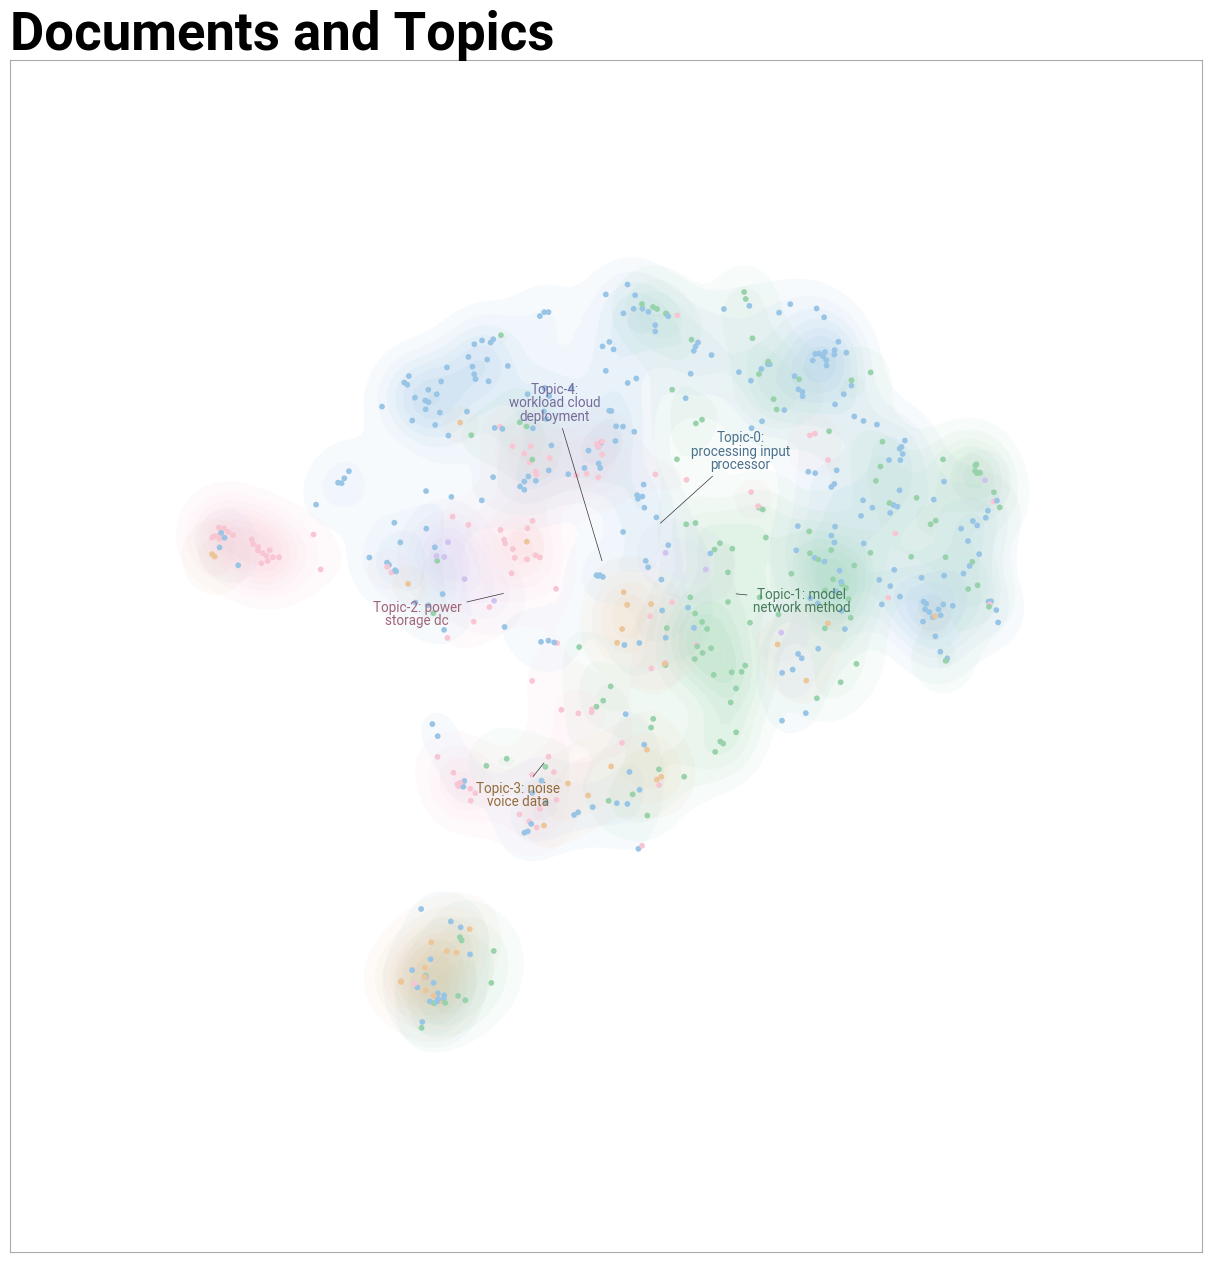

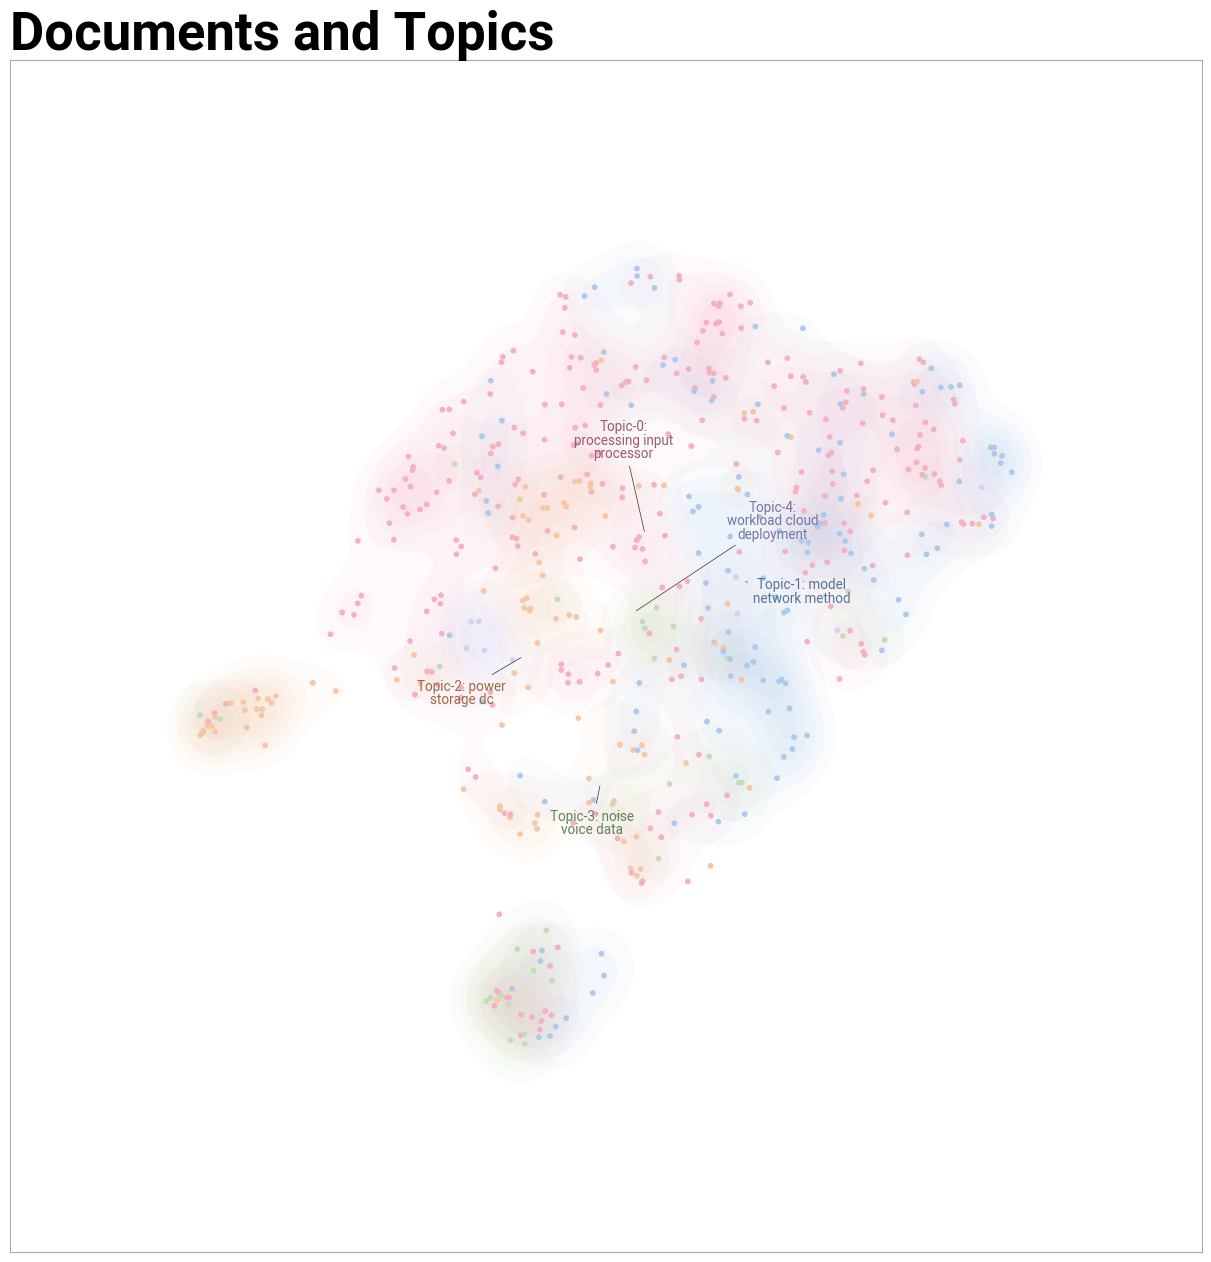

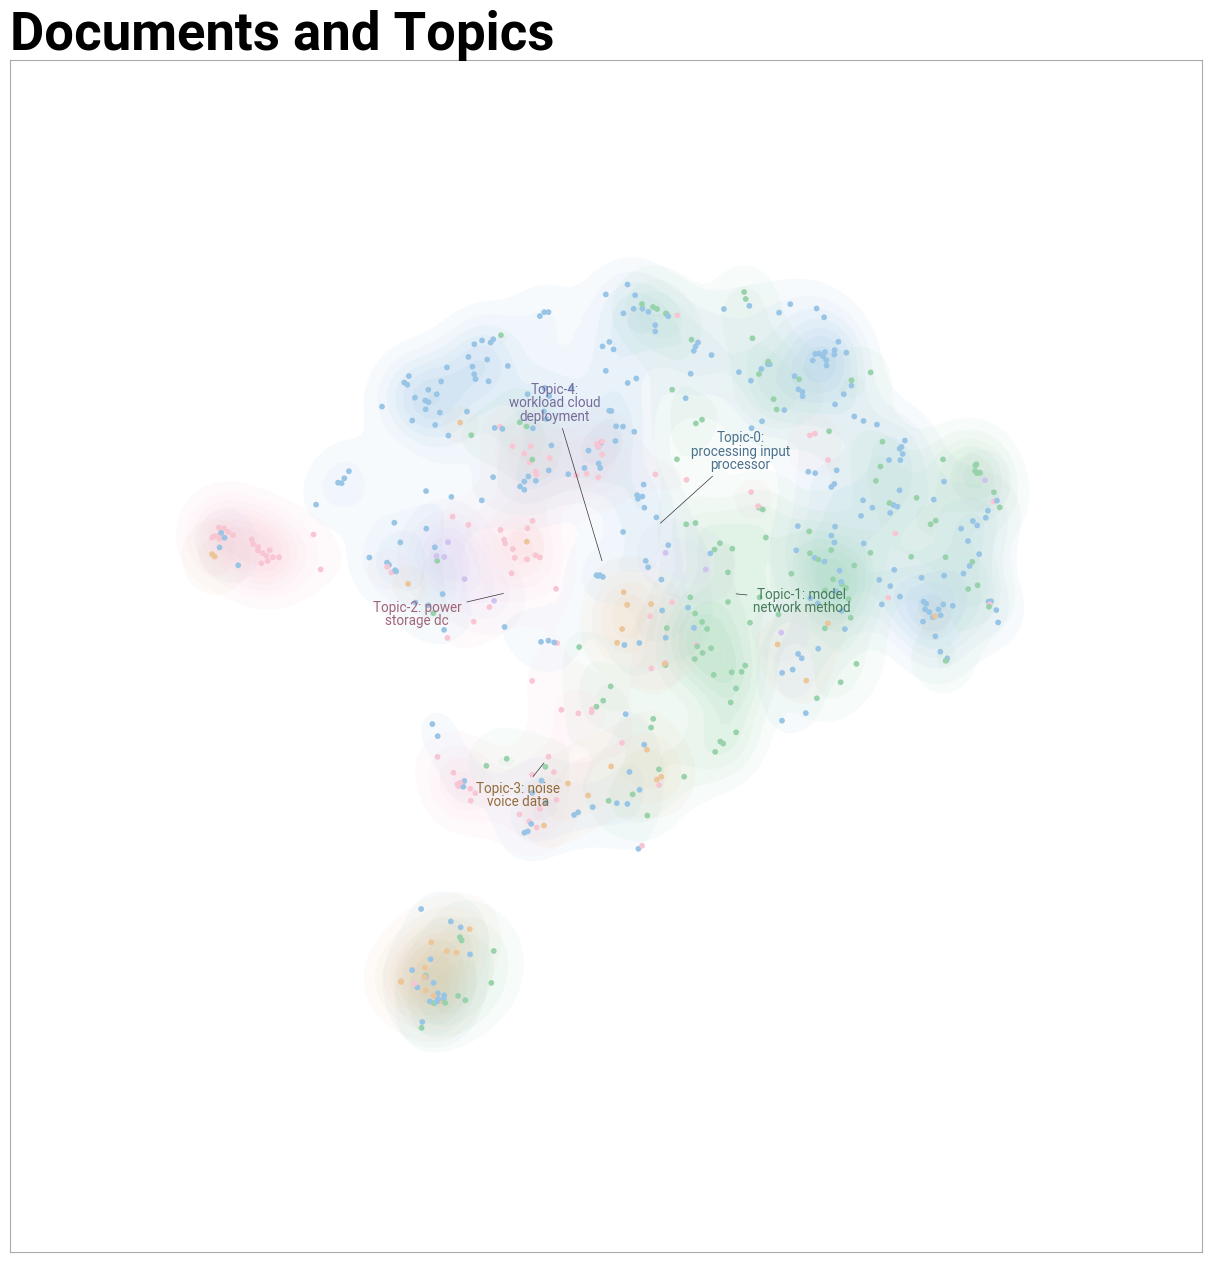

In [35]:
# Run the visualization with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings)

# with the reduced embeddings
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings)
topic_model.visualize_document_datamap(abstracts, reduced_embeddings=reduced_embeddings)


## larger SofAI

In [14]:
sofai = patents_text[patents_text['SofAI'] == 1]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = sofai['title'] + sofai['abstract'] + sofai["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [5]:
# precalculate embeddings: 
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", revision=None)
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches: 100%|██████████| 96/96 [00:34<00:00,  2.78it/s]


In [11]:
# precalculate embeddings: 
embedding_model = SentenceTransformer("pritamdeka/S-Scibert-snli-multinli-stsb", revision=None)
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)        


Batches: 100%|██████████| 96/96 [01:26<00:00,  1.10it/s]


In [15]:
# precalculate embeddings: 
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)
embeddings_specter = embedding_model_specter.encode(abstracts, show_progress_bar=True)        


Batches: 100%|██████████| 96/96 [06:16<00:00,  3.92s/it]


In [ ]:
# precalculate embeddings: 
embedding_model_t5 = SentenceTransformer("sentence-transformers/sentence-t5-base", revision=None)
embeddings_t5 = embedding_model_t5.encode(abstracts, show_progress_bar=True)        



In [39]:
from transformers.pipelines import pipeline

embedding_model_scibert = pipeline("feature-extraction", model="allenai/scibert_scivocab_uncased")
embeddings_scibert = embedding_model_scibert.encode(abstracts, show_progress_bar=True)        


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


AttributeError: 'FeatureExtractionPipeline' object has no attribute 'encode'

In [68]:
zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "storage, data center, server, uninterruptible power supply, router, network switches, firewalls, power distribution unit, rectifier, isolator, circui breaker", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory, wafer-scale engines, integrated circuits, FPGA", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]

topic_model = BERTopic(embedding_model=embedding_model_specter,
    min_topic_size=50,
    top_n_words=25,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.50,
    vectorizer_model = CountVectorizer(stop_words="english"),
    representation_model= MaximalMarginalRelevance(diversity=0.4)
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings=embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1994,"storage, data center, server, uninterruptible ...","[power, voltage, circuit, dc, converter, curre...",[power supply unit and information processora ...
1,1,335,"sensor data collection, environmental monitori...","[device, voice, application, mobile, wireless,...","[data processing method, data processing devic..."
2,2,324,"computing hardware, processors, GPU, cooling, ...","[plurality, chip, integrated, computing, perfo...",[compute optimizations for low precision machi...
3,3,210,"algorithmic design, model architecture, layer,...","[neural, network, learning, processing, layer,...",[search method for machine learning model and ...
4,4,121,"network infrastructure, bandwidth, data transm...","[transmission, bandwidth, device, packets, wir...","[signal encoding method and device, method for..."
5,5,64,"deployment, edge and cloud","[network, virtual, plurality, resource, device...","[access method, and terminalthe application di..."


In [48]:
# Number of words to display for each topic
num_words = 20

# Get topic information
topic_info = topic_model.get_topic_info()

# Display more words for each topic
for topic_num in topic_info.Topic:
    if topic_num == -1:  # Skip outliers
        continue
    topic_words = topic_model.get_topic(topic_num)[:num_words]
    print(f"Topic {topic_num}: {topic_info.loc[topic_info.Topic == topic_num, 'Name'].values[0]}")
    for word, score in topic_words:
        print(f"{word}: {score}")
    print("\n")

Topic 0: data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer
power: 0.07879349867104735
voltage: 0.0525116179022331
circuit: 0.043884656451695404
dc: 0.037833538725193315
converter: 0.03471258931966311
device: 0.033307862642043426
current: 0.03287416843902645
switch: 0.02406639518007213
ac: 0.023302336894062265
battery: 0.0180916097700121


Topic 1: computing hardware, processors, GPU, cooling, memory
memory: 0.06765054797308649
processor: 0.047633401548673245
computing: 0.03095708256610216
unit: 0.026601235373253377
neural: 0.026303049591558915
cache: 0.026219701883739524
performance: 0.025031739473293894
input: 0.024366529148717203
accelerator: 0.023526778470455787
hardware: 0.019242821400632982


Topic 2: sensor data collection, environmental monitoring, IoT sensors
processing: 0.04321378560664714
image: 0.04080532406933982
method: 0.038802653498026446
mobile: 0.030706099243895578
application: 0.025045423

In [42]:
for i in range(0,7):
    print(f"Topic {i}")
    print(topic_model.get_topic(i, full=True))

Topic 0
{'Main': [('power', 0.06772789170207723), ('voltage', 0.05179867350773933), ('circuit', 0.044075556685519046), ('dc', 0.04021337704133319), ('converter', 0.03564497567061843), ('current', 0.03435212598047529), ('device', 0.029502892762747892), ('switch', 0.024392065766620678), ('invention', 0.022014839510857837), ('capacitor', 0.017112393776950747)]}
Topic 1
{'Main': [('power', 0.08688149000638833), ('battery', 0.050583575027629), ('device', 0.04051426752419397), ('voltage', 0.038788030089777714), ('circuit', 0.031446162310695976), ('converter', 0.022570676136530333), ('dc', 0.02004857552538121), ('current', 0.01970831765539888), ('electric', 0.01828219070019922), ('switch', 0.017300647041496062)]}
Topic 2
{'Main': [('processing', 0.06333600720188548), ('processor', 0.045888227826997675), ('computing', 0.03075409917778044), ('operations', 0.02877690202141937), ('neural', 0.02626992276143503), ('cache', 0.024413122377820944), ('unit', 0.02409884113994736), ('accelerator', 0.0236

In [49]:
topic_model.visualize_topics()

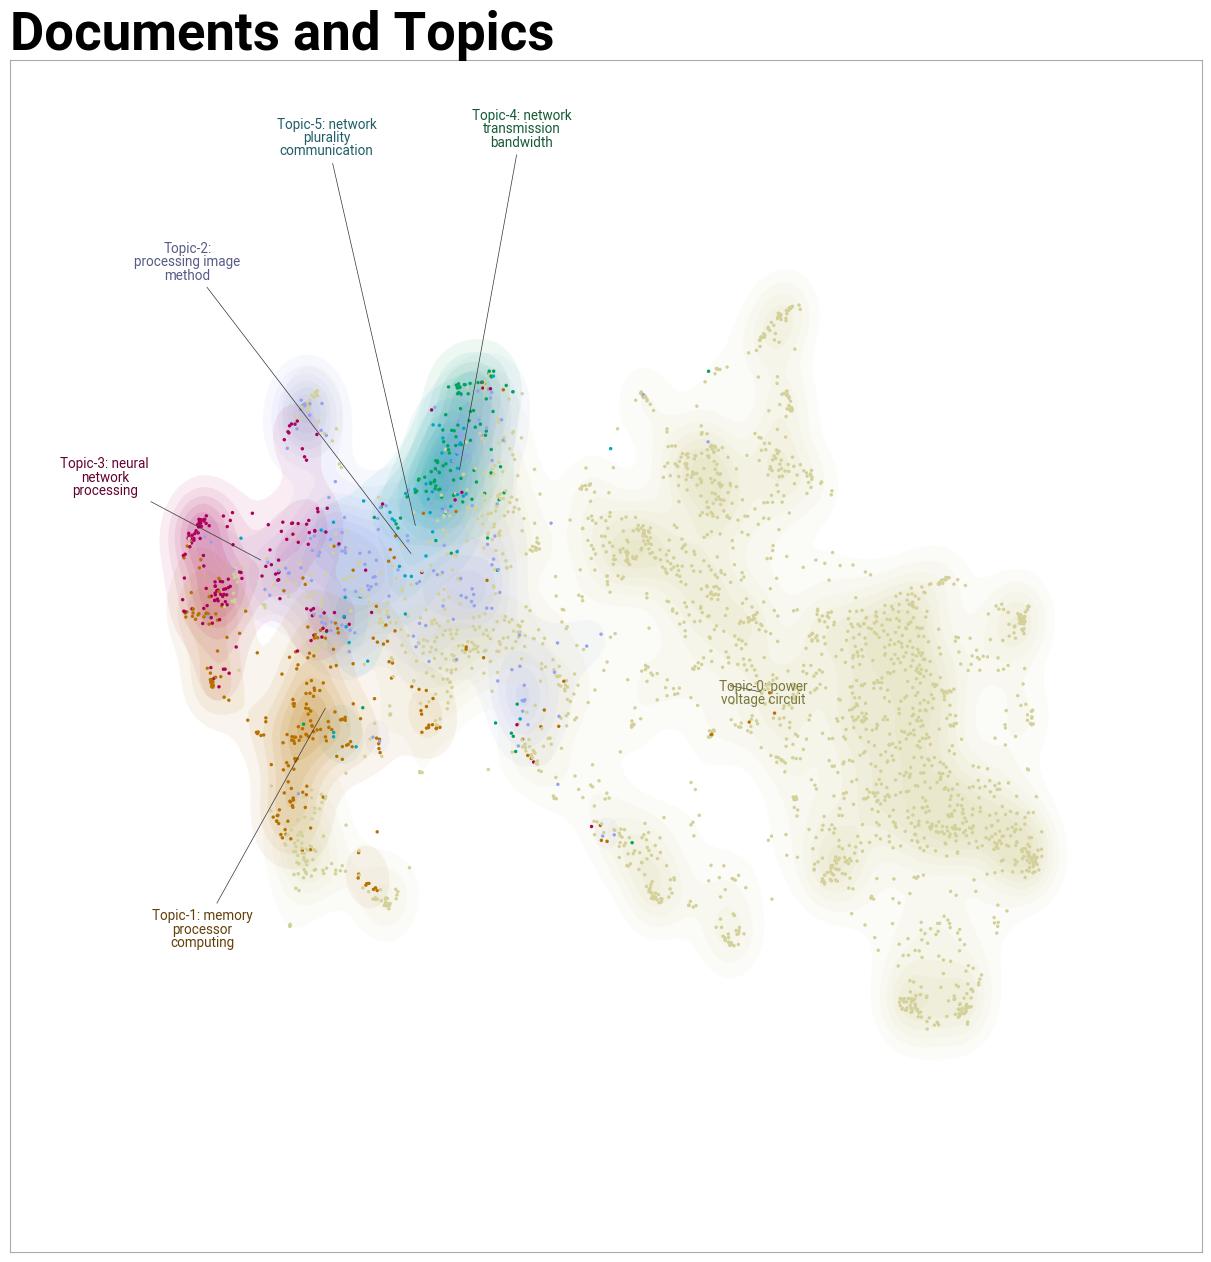

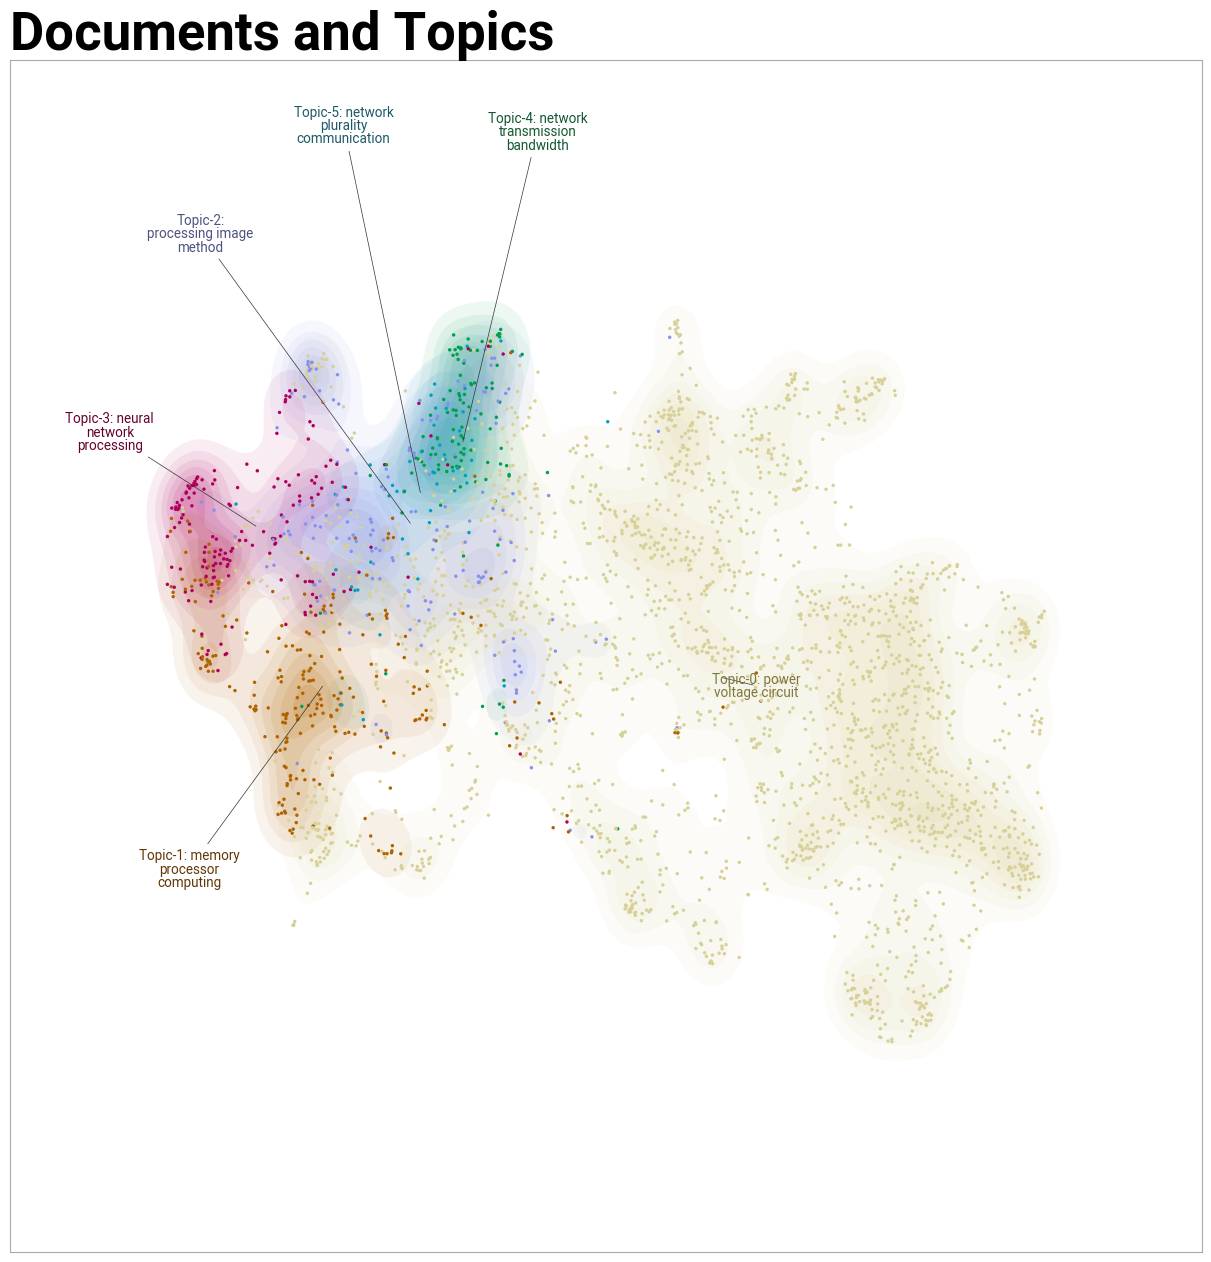

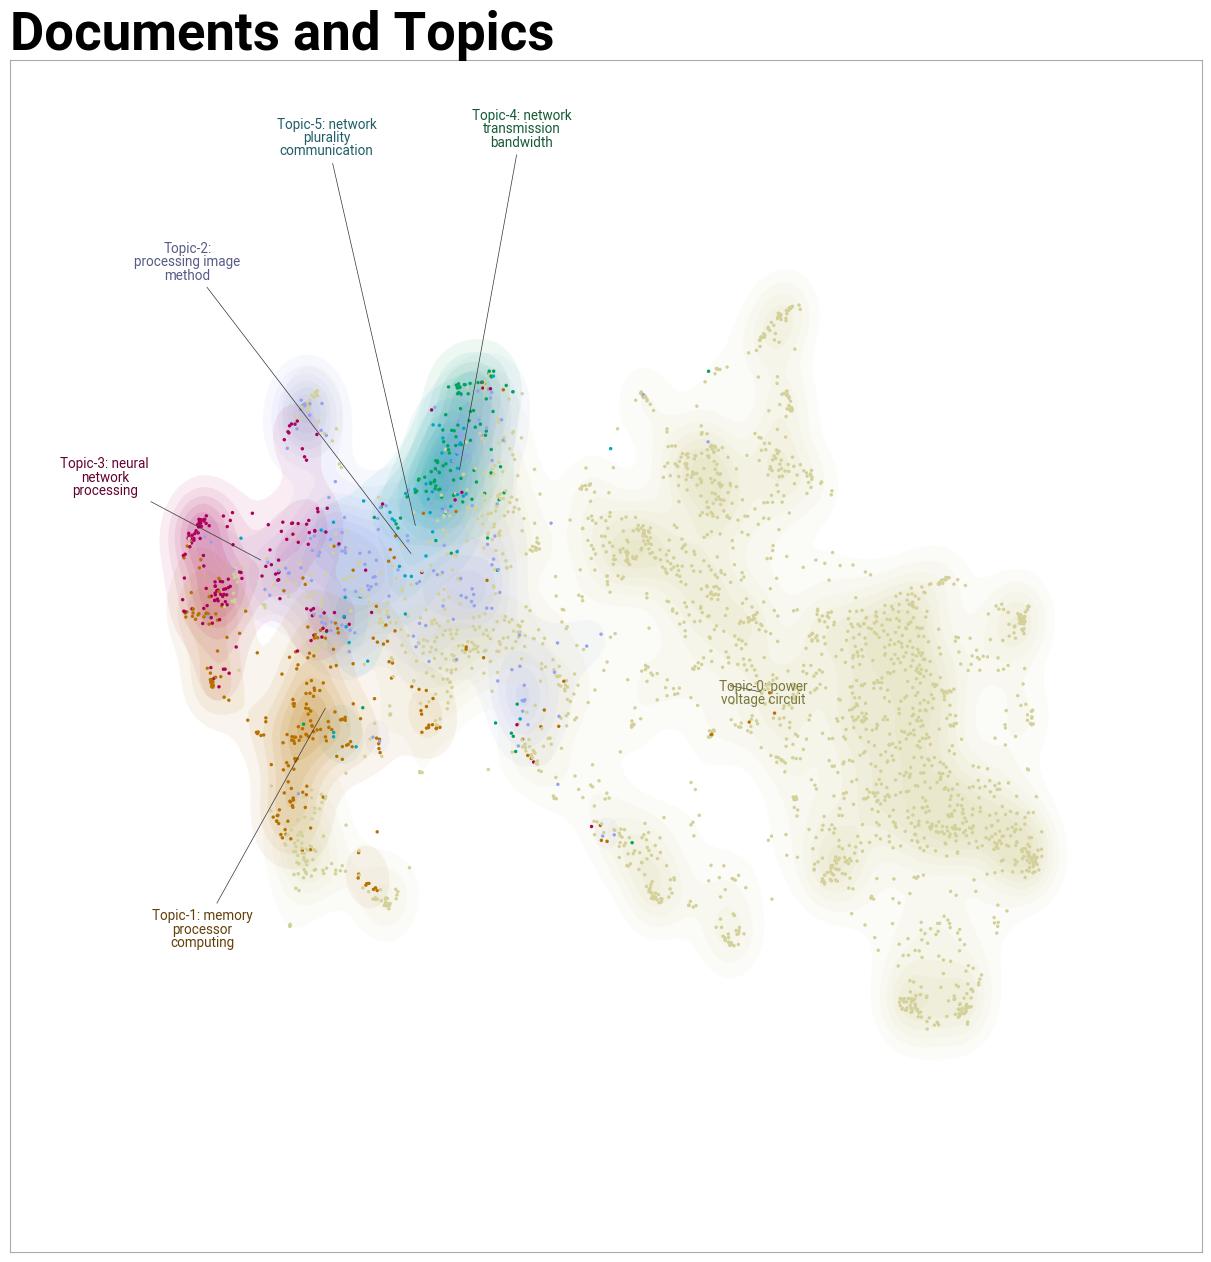

In [67]:
# Run the visualization with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings_specter)

# with the reduced embeddings
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings_specter)
topic_model.visualize_document_datamap(abstracts, reduced_embeddings=reduced_embeddings)


In [51]:
topic_model.visualize_heatmap()

In [53]:
topic_model.visualize_term_rank()

In [60]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()

In [64]:
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)

In [65]:
topic_model.visualize_topics_over_time(topics_over_time)

In [17]:
zeroshot_topic_list = [
    "sensor data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller", # general data center infrastructure
    "algorithmic design, model architecture, layer, deep learning, weights", # model development
    "computing hardware, processors, GPU, memory, RAM, cache, wafer-scale engines, integrated circuits, FPGA, chassis, integrated network controller", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "deployment, edge and cloud" # deployment
    ]

topic_model = BERTopic(embedding_model=embedding_model_specter,
    min_topic_size=50,
    top_n_words=25,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.50,
    vectorizer_model = CountVectorizer(stop_words="english"),
    representation_model= MaximalMarginalRelevance(diversity=0.4)
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings=embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1909,"data center, uninterruptible power supply, pow...","[power, voltage, circuit, dc, converter, curre...",[dc power supplya dc power supply including a ...
1,1,272,"computing hardware, processors, GPU, memory, R...","[memory, chip, integrated, bus, performance, p...",[integrated circuit chip deviceprovided are an...
2,2,259,"network infrastructure, bandwidth, data transm...","[device, transmission, voice, invention, wirel...",[method and apparatus for bandwidth management...
3,3,205,"sensor data collection, environmental monitori...","[processing, method, device, application, mobi...",[information processing method and terminal de...
4,4,179,"algorithmic design, model architecture, layer,...","[neural, network, processing, layer, machine, ...",[search method for machine learning model and ...
5,5,177,"storage, storage area network, network-attache...","[memory, storage, disk, present, devices, acce...",[clock mode determination in a memory systema ...
6,6,47,"deployment, edge and cloud","[virtual, plurality, resource, device, wireles...",[method of operating a communication device an...


In [18]:
# Number of words to display for each topic
num_words = 20

# Get topic information
topic_info = topic_model.get_topic_info()

# Display more words for each topic
for topic_num in topic_info.Topic:
    if topic_num == -1:  # Skip outliers
        continue
    topic_words = topic_model.get_topic(topic_num)[:num_words]
    print(f"Topic {topic_num}: {topic_info.loc[topic_info.Topic == topic_num, 'Name'].values[0]}")
    for word, score in topic_words:
        print(f"{word}: {score}")
    print("\n")

Topic 0: data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller
power: 0.08304682097403418
voltage: 0.05692794540756758
circuit: 0.04546315988578055
dc: 0.04258624300786256
converter: 0.03899119285397798
current: 0.03630126775393201
device: 0.029793972103577173
switch: 0.026886853105916462
invention: 0.021302696129192732
capacitor: 0.017709282299105154


Topic 1: computing hardware, processors, GPU, memory, RAM, cache, wafer-scale engines, integrated circuits, FPGA, chassis, integrated network controller
memory: 0.05191473777802558
chip: 0.03328685239292392
integrated: 0.026315030327083776
bus: 0.026085282086680303
performance: 0.020239767313327363
processors: 0.02018927886705379
invention: 0.018472972599221132
computing: 0.01763604150651302
cache: 0.017532970723332403
devices: 0.01653526332569658


Topic 2: network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity
device: 0.042254694

## field of the invention

remove empty descriptions!

In [4]:
sofai = patents_text[(patents_text['SofAI'] == 1)]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = sofai["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [7]:
len(abstracts)

3048

In [12]:
print(abstracts[5])

In [5]:
# precalculate embeddings: 
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)
embeddings_specter = embedding_model_specter.encode(abstracts, show_progress_bar=True)        


Batches: 100%|██████████| 96/96 [02:37<00:00,  1.64s/it]


In [8]:
zeroshot_topic_list = ["sustainability", "energy efficiency", "resource efficiency", "waste reduction", "emission reduction"]

topic_model = BERTopic(embedding_model=embedding_model_specter,
    min_topic_size=50,
    top_n_words=25,
    #zeroshot_topic_list=zeroshot_topic_list,
    #zeroshot_min_similarity=.50,
    vectorizer_model = CountVectorizer(stop_words="english"),
    representation_model= MaximalMarginalRelevance(diversity=0.4)
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings=embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1583,0____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , ]"
1,1,1465,1_power_voltage_circuit_dc,"[power, voltage, circuit, dc, invention, curre...",[technical field the present invention relates...


## AI for S

In [30]:
aifs = patents_text[patents_text['AIforS'] == 1 & patents_text['SofAI'] == 0]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts_aifs = aifs['title'] + aifs['abstract'] + aifs["description"].fillna('').apply(extract_first_300_words)
abstracts_aifs = abstracts_aifs.apply(str).tolist()

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

In [26]:
def extract_cpc_prefix_set(cpc_string):
    cpc_string = cpc_string.strip("[]").replace("'", "")
    cpc_list = cpc_string.split(", ")
    cpc_prefixes = [code[:3] for code in cpc_list]
    return set(cpc_prefixes)

# Apply the function to each row in the 'cpc_codes_EPO' column
aifs['cpc_code_set'] = aifs['cpc_codes_EPO'].apply(extract_cpc_prefix_set)

print(aifs.cpc_code_set)


0                  {B01}
1             {Y02, B60}
2        {Y02, H04, G06}
3        {Y02, H02, Y04}
4             {Y02, H02}
              ...       
20440         {Y04, H02}
20441    {Y02, B60, H02}
20442         {Y02, H02}
20443         {Y02, H05}
20444         {Y02, H05}
Name: cpc_code_set, Length: 19802, dtype: object


In [28]:
# Convert sets to frozensets to make them hashable
frozenset_list = aifs['cpc_code_set'].apply(frozenset)

# Get the number of unique frozensets
unique_frozensets = frozenset_list.nunique()

print("Number of unique sets of CPC code prefixes:", unique_frozensets)

Number of unique sets of CPC code prefixes: 3593


In [21]:
# precalculate embeddings: 
embedding_model_minilm = SentenceTransformer("all-MiniLM-L6-v2", revision=None)
embeddings_minilm_aifs = embedding_model_minilm.encode(abstracts_aifs, show_progress_bar=True)        


Batches: 100%|██████████| 619/619 [06:13<00:00,  1.66it/s]
